# SI 670: Applied Machine Learning Final Project
## Music Genre Classification
Matt Whitehead (mwwhite)

## Introduction

Music genre classification is an interesting problem from a research standpoint as well as having wide ranging commercial applications. Multiple approaches to this problem have been documented using both traditional machine learning methods and deep convolutional neural networks. The goal of this project at a high-level is to explore the existing methodologies, explore the potential use of recurrent neural networks (RNNs) for this task, and assess if existing techniques can be improved through ensembling methods.

This notebook uses the public GTZAN dataset from the University of Victoria which is available: [here](http://opihi.cs.uvic.ca/sound/genres.tar.gz)

## Traditional Machine Learning

### Feature Extraction
We begin by extracting audio features using a similar process to [this one](https://github.com/Hguimaraes/gtzan.keras/blob/master/nbs/handcrafted.ipynb). However, rather than limiting the FFT window size to 1024, I use the default value of 2048. As far as I can tell, the only reason for limiting the window size is to speed up processing time. Since my computer seems to be able to handle the additional load, I have decided not to do this. I also use the default value of 20 for n_mfcc rather than 13. I've seen 13 described in speech recognition algorithms as an appropriate value, however unless proven otherwise, I'm going to operate under the assumption that more data is better than less data. I also handle file I/O and conversion to a pandas DataFrame differently.

### Feature Descriptions
Taken from the [librosa documentation](https://librosa.github.io/librosa/index.html).

* Spectral Centroid
    * Each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame.
* Spectral Rolloff
    * The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below. This can be used to, e.g., approximate the maximum (or minimum) frequency by setting roll_percent to a value close to 1 (or 0).
* Zero Crossing Rate
    * The zero-crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval, being a key feature to classify percussive sounds.
    * From [Wikipedia](https://en.wikipedia.org/wiki/Zero-crossing_rate)
* RMSE
    * Compute root-mean-square (RMS) energy for each frame...from the audio samples...
* Flux
    * Compute a spectral flux onset strength envelope.
    * Onset strength at time t is determined by:
    * mean_f max(0, S[f, t] - ref_S[f, t - lag])
    * where ref_S is S after local max filtering along the frequency axis [1].
* Tempo
    * Estimate the tempo (beats per minute)

Each of these features (with the exception of tempo) were extracted for each frame in the spectogram of each song. Each of these feature vectors are highly dimentional (over 2000 dimentions), so in order to avoid having extremely dimentional data each feature vector was treated as a distribution from which the mean, standard deviation, kurtosis, and skew were computed. The intuition here is to allow dimensionality reduction while still preserving a good summary representation of each song. 

In [1]:
import librosa
from os import listdir
from scipy.stats import skew, kurtosis
import numpy as np
import pandas as pd

In [58]:
def extract_features(genre):
    # walk through the given dir
    for idx, song in enumerate(listdir('genres/' + genre + '/')):
        
        # use librosa to extract features
        ts, sr = librosa.load('genres/' + genre + '/' + song)
        features = {}
        features['centroid'] = librosa.feature.spectral_centroid(ts, sr=sr).ravel()
        features['rolloff'] = librosa.feature.spectral_rolloff(ts, sr=sr).ravel()
        features['zcr'] = librosa.feature.zero_crossing_rate(ts).ravel()
        features['rmse'] = librosa.feature.rmse(ts).ravel()
        features['flux'] = librosa.onset.onset_strength(ts, sr=sr)
        
        # extract MFCCs and iterate
        mfcc = librosa.feature.mfcc(ts, sr=sr)
        for i, v in enumerate(mfcc):
            features['mfcc_{}'.format(i)] = v.ravel()
        
        # get summary features
        agg_features = {}
        for i,v in features.items():
            agg_features['{}_mean'.format(i)] = np.mean(v)
            agg_features['{}_std'.format(i)] = np.std(v)
            agg_features['{}_kurtosis'.format(i)] = kurtosis(v)
            agg_features['{}_skew'.format(i)] = skew(v)
        agg_features['tempo'] = librosa.beat.tempo(ts, sr=sr)[0]
            
        # create a df if it doesn't exist, otherwise append the extracted features
        if idx == 0:
            extracted = pd.DataFrame(agg_features, index=[idx])
        else:
            extracted = extracted.append(pd.DataFrame(agg_features, index=[idx]), sort=True)
            
    extracted['genre'] = genre
            
    return extracted

In [59]:
%time full_data = extract_features('pop')

/anaconda3/envs/siaml/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


CPU times: user 2min 24s, sys: 5.11 s, total: 2min 29s
Wall time: 1min 30s


In [60]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'reggae', 'rock']

In [61]:
# this takes about 20 minutes to run on my computer
# your mileage may vary
for i in genres:
    genre_data = extract_features(i)
    full_data = full_data.append(genre_data)

In [63]:
full_data.reset_index(inplace=True, drop=True)

In [65]:
full_data.to_csv('full_data.csv', index=False)

### Visualizing Data

As the data is highly dimensional, it will have to be projected into a lower dimentional space in order to be visualized. Here I used both t-SNE and PCA to produce visualizations. The t-SNE visualization attempts to preserve the aproximate distance between datapoints in 100d vector space. Intuitively pop and and classical music seem to be on the furthest apart in the vector space whereas jazz and classical seem to be quite close together. 

The PCA visualization shows a nicely layered funnel shape where the genres cluster together quite well. This likley explains the success of an SVM (with RBF kernel) classifier on this dataset.

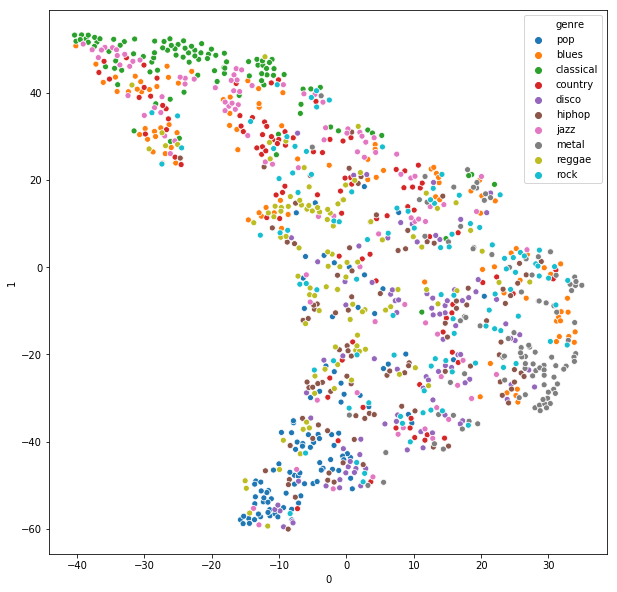

In [109]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

X = full_data.drop('genre', axis=1).copy()
y = full_data['genre'].copy()

X_tsne = TSNE(2).fit_transform(X)
X_tsne = pd.DataFrame(X_tsne)
X_tsne['genre'] = y

plt.figure(figsize=(10,10))
sns.scatterplot(x=X_tsne[0], y=X_tsne[1], hue=X_tsne['genre'])

In [111]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [112]:
X_scaled = StandardScaler().fit_transform(X)
X_pca = PCA(2).fit_transform(X_scaled)

/anaconda3/envs/siaml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/siaml/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [114]:
X_pca = pd.DataFrame(X_pca)
X_pca['genre'] = y

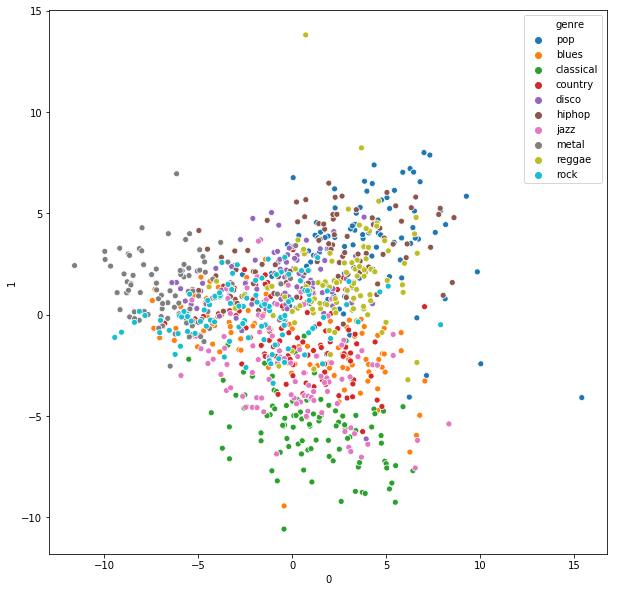

In [115]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=X_pca[0], y=X_pca[1], hue=X_pca['genre'])

### Modeling Data

On the [GitHub repository](https://github.com/Hguimaraes/gtzan.keras) for this dataset, we're given the following baseline classifiers:

| Model | Acc | Std |
|-------|-----|-----|
| Decision Tree | 0.502 | 0.03 |
| Logistic Regression | 0.700 | 0.013 |
| Random Forest | 0.708 | 0.032 |
| SVM (RBF) | 0.762 | 0.034 |

I decieded to dispense with the decision tree classifier since the algorithm is highly prone to overfitting and empirically performed the worst. I instead decided to try a Gradient Boosted Forest, the results of which were underwhelming (though far better than a decision tree). In order to remain consistent with the author of the repository, I also tested my models with 5-fold cross validation and reported the mean accuracy and standard deviation. My results were as follows:

| Model | Acc | Std |
|-------|-----|-----|
| Logistic Regression | 0.748 | 0.014 |
| Random Forest | 0.725 | 0.024 |
| SVM (RBF) | 0.787 | 0.03 |
| Gradient Boosted Forest | 0.706 | 0.025 |

All of my classifiers significantly outperformed the baseline classifiers provided by the author. My initial thought was that I may have been leaking data somewhere in the training process. I found that I had been fitting the StandardScaler used by my SVM model on the full dataset before cross validating. However, after correcting this mistake my model's accuracy decreased only slightly. With this in mind, I've concluded that either the different parameters I selected during feature extraction were superior, the hyper parameters of my models were better calibrated, or a combination of both. In particular, the performance of my models were very similar to the author's prior to hyperparamter tuning. However, after performing a cross-validated grid search, the model performance increased significantly. Since the author's primary approach to this problem uses a convolutional neural network, it may be that he did not bother to tune the other models and merely provided them as a measure of baseline performance.

I also decided to ensemble the Logistic Regression, Random Forest, and SVM models using a "soft" VotingClassifier. The VotingClassifier accepts predictions from the base classifiers as vectors of estimated class probabilities. It then returns a final prediction using a weighted average of the class probabilities. Despite my best efforts, I could not outperform the SVM classifier with this model. In fact, at its best, it gave the exact same performance as the SVM. It's likley that when tuning the weights for the base classifiers, the values I ended up with resulted in the final predictions being identical to the SVM predictions. The results of model training and tuning are found below.

#### SVM

In [349]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline

In [360]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

In [367]:
param_grid = {'svm__C': [5, 5.1, 5.2],
              'svm__gamma': [0.0065, 0.007, 0.006]}

In [368]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

In [363]:
X = X.astype('float64')

In [369]:
grid_search.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'svm__C': [5, 5.1, 5.2], 'svm__gamma': [0.0065, 0.007, 0.006]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [370]:
grid_search.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=5.2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0065, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [408]:
svm_pipeline = Pipeline([('scaler', StandardScaler()),
                         ('svm', SVC(kernel='rbf', C=5.2, gamma=0.0065))
                        ])

In [409]:
svm_cv = cross_validate(svm_pipeline, X, y, cv=5)

In [410]:
svm_cv['test_score']

array([0.795, 0.785, 0.815, 0.81 , 0.73 ])

In [411]:
svm_cv['test_score'].mean()

0.787

In [412]:
svm_cv['test_score'].std()

0.030430248109405884

#### Random Forest

In [373]:
from sklearn.ensemble import RandomForestClassifier

In [394]:
rf_param_grid = {'n_estimators': [190, 200, 210]}

In [395]:
rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5)

In [396]:
rf_grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [190, 200, 210]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [397]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=190, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [398]:
rf = RandomForestClassifier(n_estimators=190)
rf_cv = cross_validate(rf, X, y, cv=5)

In [400]:
rf_cv['test_score']

array([0.74 , 0.68 , 0.745, 0.74 , 0.72 ])

In [401]:
rf_cv['test_score'].mean()

0.725

In [402]:
rf_cv['test_score'].std()

0.024083189157584572

#### Logistic Regression

In [414]:
from sklearn.linear_model import LogisticRegression

In [449]:
lr = LogisticRegression(solver='sag', multi_class='auto', max_iter=1000)
# scaling to allow sag fast convergence
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lr_pipeline = Pipeline([('scale', StandardScaler()),
                        ('lr', lr)
                       ])
lr_param_grid = {'lr__C': [0.1, 0.05, 0.04, 0.03, 0.02]}
lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=5)

In [450]:
lr_grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lr__C': [0.1, 0.05, 0.04, 0.03, 0.02]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [451]:
lr_grid.best_estimator_

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False))])

In [452]:
lr_grid.best_score_

0.748

In [454]:
lr_tuned = LogisticRegression(solver='sag', multi_class='auto', max_iter=1000, C=0.05)
lr_pipeline = Pipeline([('scale', StandardScaler()),
                        ('lr', lr_tuned)
                       ])
lr_cv = cross_validate(lr_pipeline, X, y, cv=5)

In [455]:
lr_cv['test_score']

array([0.77 , 0.735, 0.76 , 0.74 , 0.735])

In [456]:
lr_cv['test_score'].mean()

0.748

In [457]:
lr_cv['test_score'].std()

0.014352700094407337

#### Gradient Boosted Forest

In [458]:
from sklearn.ensemble import GradientBoostingClassifier

In [460]:
gbf = GradientBoostingClassifier()
gbf_param_grid = {'n_estimators': [50, 100, 150],
                  'learning_rate': [0.05, 0.1, 0.15]}
gbf_grid = GridSearchCV(gbf, gbf_param_grid, cv=5)

In [461]:
gbf_grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [462]:
gbf_grid.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [463]:
gbf_grid.best_score_

0.709

In [465]:
# the best estimator used the default params
gbf_cv = cross_validate(gbf, X, y, cv=5)

In [466]:
gbf_cv['test_score']

array([0.68 , 0.715, 0.72 , 0.74 , 0.675])

In [467]:
gbf_cv['test_score'].mean()

0.7060000000000001

In [468]:
gbf_cv['test_score'].std()

0.024779023386727706

#### Ensemble Voting Classifier

In [480]:
# leaving out the GBF as it's the worst one and takes forever to train
clf1 = Pipeline([('scaler',StandardScaler()),
                 ('svm', SVC(kernel='rbf', C=5.2, gamma=0.0065, probability=True))
                ])
clf2 = RandomForestClassifier(n_estimators=190)
clf3 = Pipeline([('scaler', StandardScaler()),
                 ('lr', LogisticRegression(solver='sag', 
                                           multi_class='auto', 
                                           max_iter=1000, C=0.05))
                ])

In [472]:
from sklearn.ensemble import VotingClassifier

In [514]:
ensemble = VotingClassifier(estimators=[('svm', clf1), ('rf', clf2), ('lr', clf3)],
                            voting='soft')

In [505]:
ensemble_cv = cross_validate(ensemble, X, y, cv=5)

In [506]:
ensemble_cv['test_score'].mean()

0.786

In [490]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=190, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [518]:
def generate_grid(w1, w2, w3):
    grid = []
    for i in w1:
        for j in w2:
            for z in w3:
                grid.append([i, j, z])
    return grid

In [532]:
ensemble_grid = generate_grid([1.4, 1.5, 1.6], [0.7, 0.6, 0.5], [1, 0.9, 1.1])

In [533]:
scores = []
for i in ensemble_grid:
    ensemble = VotingClassifier(estimators=[('svm', clf1), ('rf', clf2), ('lr', clf3)],
                            voting='soft', weights=i)
    ensemble_cv = cross_validate(ensemble, X, y, cv=5)
    score = ensemble_cv['test_score'].mean()
    scores.append((score, i))

In [535]:
sorted(scores, reverse=True)[0]

(0.787, [1.4, 0.7, 0.9])